In [2]:
### '''Installation'''
# !pip install qiskit[visualization]==1.1.0
# # Use the following if you are on MacOS/zsh
# #!pip install 'qiskit[visualization]'==1.1.0
# !pip install qiskit_aer
# !pip install qiskit_ibm_runtime
# !pip install matplotlib
# !pip install pylatexenc
# !pip install prototype-zne

# 1-D Schrodinger equation
 Schrodinger equation:
$$-i\hbar \frac{d \ket{\psi}}{dt} = H \ket{\psi}  $$

The Hamiltonian H of the system is:
$$T+V = \frac{p^2}{2m} + V$$
where p is momentum operator, V is potential operator and K is Kinetic Energy operator.

Its evolution is given by equation: $$|\psi(x,t)\rangle =  e^{-iHt} |\psi(x,0)\rangle$$

The unitary operator is $U=e^{-iHt}$



## Trotterization of Hamiltonian H

T and V are non commuting operators, i,e $[T,V]\neq 0$

Hence, Hamiltonian H need to be decomposed using trotterization

### Lie Trotter Method
$$e^{i(A+B)n\Delta t} \approx (e^{iA\Delta t} e^{iB\Delta t})^n $$
Lie-Trotter decomposition of H
$$
U =e^{-i\hat{H}t} \approx \left(e^{-i\hat{T}\\Delta t} e^{-\hat{V}\Delta t}\right)^n
$$


<!-- <details>
<summary>Lie-Trotter decomposition of H  </summary>

inside text
</details> -->

### Suzuki Trotter Method
$$e^{i(A+B)n\Delta t} \approx (e^{i\frac{A}{2}\Delta t} e^{iB\Delta t} e^{i\frac{A}{2}\Delta t})^n $$
Suzuki-Trotter decomposition of H

$$e^{-i\hat{H}t/\hbar} \approx  \left( e^{-i\hat{V} \Delta t/2} e^{-iT\Delta t} e^{-i\hat{V} \Delta t/2} \right)^n
$$
<!-- <details>
<summary> Suzuki-Trotter decomposition of H</summary>
inside text
</details> -->
Since $\hat{T}=\frac{\hat{p}^2 }{2m}$ which is in momentum space, for applying operator T, the  basis need to be transformed to momentum space and revert back to computation space after applying the gate. We can achieve by using Fourier Transform: Quantum Fourier transform for quantum computers. So the operation would become:

$$e^{-i\hat{V} \Delta t/2} QFT e^{-iT\Delta t} QFT_{inv} e^{-i\hat{V} \Delta t/2}$$


We have $\hat{T} = \frac{\hat{p}^2 }{2 }$(let m=1 for simplicity), we can write $\hat{p}$ as :
$$
\hat{p} = -\sqrt{\frac{1}{2^{2n-3} } \frac{\phi}{\Delta t}} \left(1 + \sum_{j=1}^{n} 2^{n-j} \hat{Z_j}\right)
$$

The whole equation $e^{i\hat{p}^2\Delta t}$ becomes
$$
e^{i\hat{p}^2\Delta t} = exp\left(\frac{i\phi}{2^{2n-3}} \left(1 + \sum_{j=1}^{n} 2^{n-j} \hat{Z_{j}}\right)^2\right)
$$


## Free Particle: V=0
$$U = QFT e^{-iT\Delta t} QFT_{inv} $$



In [3]:
# import of required libraries and modules
from math import pi
import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.visualization import plot_histogram, plot_distribution
from qiskit.circuit.library import QFT
from qiskit.primitives import StatevectorSampler,Sampler,Estimator

### Initial wavefunction
For now, We will be working on a Gaussian stationary wavefunction with no initial kinetic energy $k_0=0$:
$$\psi(x,t_{0}) = \frac{1}{\sigma\sqrt{2\pi}} e^{-\frac{1}{2}\left(\frac{x-x_{0}}{\sigma}\right)^{2}} e^{i\hbar k_{0}x}$$

Since $k_0=0$, we can exclude the last term and $\psi$ becomes:
$$\psi(x,t_{0}) = \frac{1}{\sigma\sqrt{2\pi}} e^{-\frac{1}{2}\left(\frac{x-x_{0}}{\sigma}\right)^{2}}

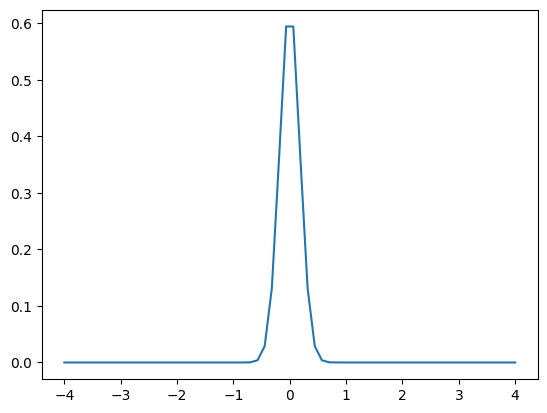

In [4]:
# Preparing the Gaussian-shaped histogram that will be used in the initialisation

x = np.linspace(-4,4, num=64)
x0=0


'''wavefunction: guassian wavepacket'''
pos=0
unnormalized_wavefunction = (1/(np.sqrt(2*np.pi)*0.4)*np.exp(-(0.5*(x-x0)**2)/(0.016)))


Normalisation_Constant = np.sqrt(np.sum(np.abs(unnormalized_wavefunction**2)))

wavefunction = (unnormalized_wavefunction)/(Normalisation_Constant)


plt.plot(x,wavefunction)
plt.show()


In [5]:
sampler = StatevectorSampler()

def initialization(qc,wavefunction,q_reg):

    qc.initialize(wavefunction, q_reg)

def apply_QFT(qc,q_reg):
    qc.append(QFT(n),q_reg)


def Time_Evolution(qc,n,q_reg,aux_reg):
    # qc=QuantumCircuit(q_reg,aux_reg)
    for i in range (n):
        qc.p(phi/(2**(i+n-3)),q_reg[n-i-1])
    for i in range (n):
        for j in range (i+1,n):
            qc.cx(q_reg[n-j-1], aux_reg[0])
            qc.cx(q_reg[n-i-1], aux_reg[0])
            qc.p(phi* (2**(2-i-j)), aux_reg[0]) 
            qc.cx(q_reg[n-i-1], aux_reg[0])
            qc.cx(q_reg[n-j-1], aux_reg[0])
            # qc.barrier()
    # qc.to_gate()


def apply_invQFT(qc,q_reg):
    qc.append(QFT(n,inverse=True),q_reg)


def display_histogram(qc,q_reg,clas_reg,plot=False,hist=True):
    qc.measure(q_reg,clas_reg)
    keys = range(0,2**n)
    counts= {key: 0 for key in keys}
    qc_counts= Sampler().run(qc, shots=1024).result().quasi_dists[0]
    for key, value in qc_counts.items():
        if key in counts:
            counts[key] = value*100
    keys = list(counts.keys())
    values = list(counts.values())
    if plot:
        plt.plot(keys,values)
    if hist:
        display(plot_histogram(counts,bar_labels=False))


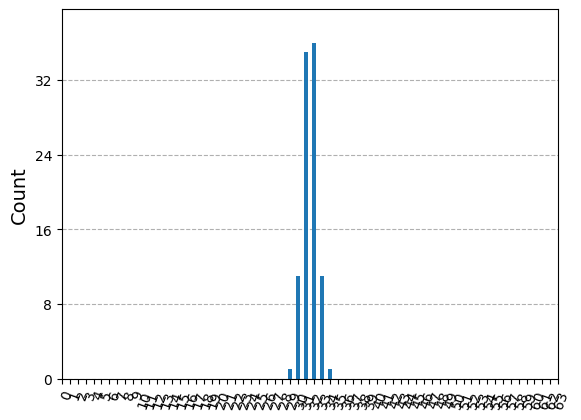

In [6]:
phi = 0.3  # function of time step
n=6
q_reg=QuantumRegister(6)
aux_reg=QuantumRegister(1)
clas_reg = ClassicalRegister(6)
qc=QuantumCircuit(aux_reg,q_reg,clas_reg)
initialization(qc,wavefunction,q_reg)

initial_qc=qc.copy()
display_histogram(initial_qc,q_reg,clas_reg)



In [7]:

# write a code for first iteration: Initialization->QFT->KE operator->inverse QFT
# initialization(qc,wavefunction,q_reg)
apply_QFT(qc,q_reg)
Time_Evolution(qc,n,q_reg,aux_reg)
apply_invQFT(qc,q_reg)
qc.draw(fold=-1)
# iter1=qc.copy()
# display_histogram(iter1,q_reg,clas_reg)


┌───┐┌───┐┌────────┐┌───┐┌───┐┌───┐┌───┐┌────────┐┌───┐┌───┐┌───┐┌───┐┌─────────┐┌───┐┌───┐┌───┐┌───┐┌──────────┐┌───┐┌───┐┌───┐┌───┐┌───────────┐┌───┐┌───┐┌───┐┌───┐┌─────────┐┌───┐┌───┐┌───┐┌───┐┌──────────┐┌───┐┌───┐┌───┐┌───┐┌───────────┐┌───┐┌───┐┌───┐┌───┐┌────────────┐┌───┐┌───┐┌───┐┌───┐┌───────────┐┌───┐┌───┐┌───┐┌───┐┌────────────┐┌───┐┌───┐┌───┐┌───┐┌─────────────┐┌───┐┌───┐┌───┐┌───┐┌─────────────┐┌───┐┌───┐┌───┐┌───┐┌──────────────┐┌───┐┌───┐┌───┐┌───┐┌──────────────┐┌───┐┌───┐         
  q1: ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤ X ├┤ X ├┤ P(0.6) ├┤ X ├┤ X ├┤ X ├┤ X ├┤ P(0.3) ├┤ X ├┤ X ├┤ X ├┤ X ├┤ P(0.15) ├┤ X ├┤ X ├┤ X ├┤ X ├┤ P(0.075) ├┤ X ├┤ X ├┤ X ├┤ X ├┤ P(0.0375) ├┤ X ├┤ X ├┤ X ├┤ X ├┤ P(0.15) ├┤ X ├┤ X ├┤ X ├┤ X ├┤ P(0.075) ├┤ X ├┤ X ├┤ X ├┤ X ├┤ P(0.0375) ├┤ X ├┤ X ├┤ X ├┤ X ├┤ P(0.01875) ├┤ X ├┤ X ├┤ X ├┤ X ├┤ P(0.0375) ├┤ X ├┤ X ├┤ X ├┤ X ├┤ P(0.01875) ├┤ X ├┤ X ├┤ X ├┤ X ├┤ P(0.009375) ├┤ X ├┤ X ├┤ X ├┤ X ├┤ P(0.009375) ├┤ X ├┤ X ├┤ X ├┤ X ├┤ P(0.0046875) ├┤ X ├┤ X ├┤ X ├┤ X ├┤ P(0.0023437) ├┤ X ├┤ X ├─────────
      ┌──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐┌──────┐┌──────────────┐└─┬─┘└─┬─┘└────────┘└─┬─┘└─┬─┘└─┬─┘└─┬─┘└────────┘└─┬─┘└─┬─┘└─┬─┘└─┬─┘└─────────┘└─┬─┘└─┬─┘└─┬─┘└─┬─┘└──────────┘└─┬─┘└─┬─┘└─┬─┘└─┬─┘└───────────┘└─┬─┘└─┬─┘└─┬─┘└─┬─┘└─────────┘└─┬─┘└─┬─┘└─┬─┘└─┬─┘└──────────┘└─┬─┘└─┬─┘└─┬─┘└─┬─┘└───────────┘└─┬─┘└─┬─┘└─┬─┘└─┬─┘└────────────┘└─┬─┘└─┬─┘└─┬─┘└─┬─┘└───────────┘└─┬─┘└─┬─┘└─┬─┘└─┬─┘└────────────┘└─┬─┘└─┬─┘└─┬─┘└─┬─┘└─────────────┘└─┬─┘└─┬─┘└─┬─┘└─┬─┘└─────────────┘└─┬─┘└─┬─┘└─┬─┘└─┬─┘└──────────────┘└─┬─┘└─┬─┘└─┬─┘└─┬─┘└──────────────┘└─┬─┘└─┬─┘┌───────┐
q0_0: ┤0                                                                                                                                                                                                                                                                                     ├┤0     ├┤ P(0.0011719) ├──┼────┼──────────────┼────┼────┼────┼──────────────┼────┼────┼────┼───────────────┼────┼────┼────┼────────────────┼────┼────■────┼─────────────────┼────■────┼────┼───────────────┼────┼────┼────┼────────────────┼────┼────┼────┼─────────────────┼────┼────■────┼──────────────────┼────■────┼────┼─────────────────┼────┼────┼────┼──────────────────┼────┼────■────┼───────────────────┼────■────┼────┼───────────────────┼────┼────■────┼────────────────────┼────■────■────┼────────────────────┼────■──┤0      ├
      │                                                                                                                                                                                                                                                                                      ││      │├──────────────┤  │    │              │    │    │    │              │    │    │    │               │    │    │    │                │    │         │                 │         │    │               │    │    │    │                │    │    │    │                 │    │         │                  │         │    │                 │    │    │    │                  │    │         │                   │         │    │                   │    │         │                    │              │                    │       │       │
q0_1: ┤1                                                                                                                                                                                                                                   

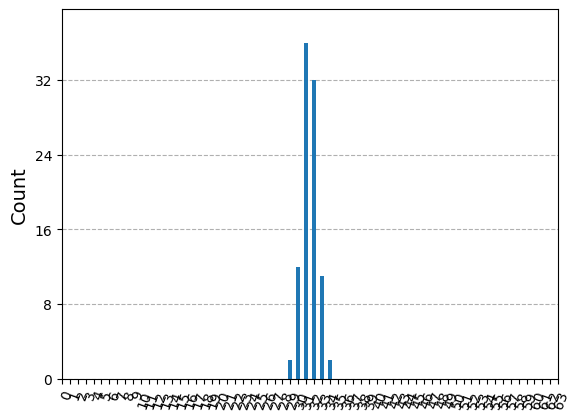

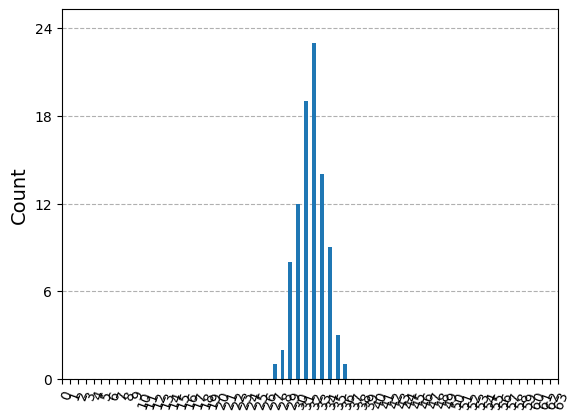

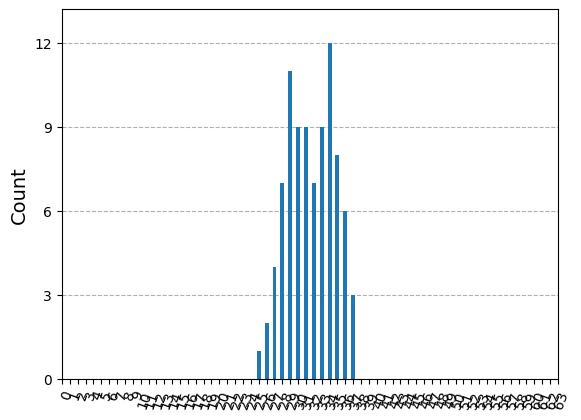

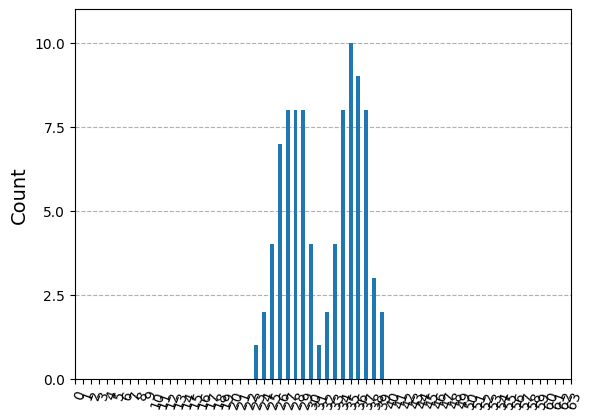

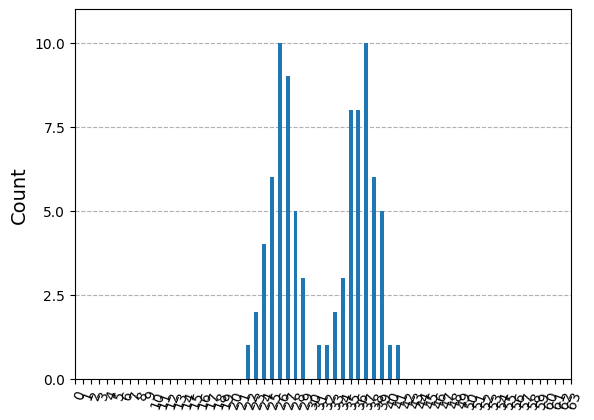

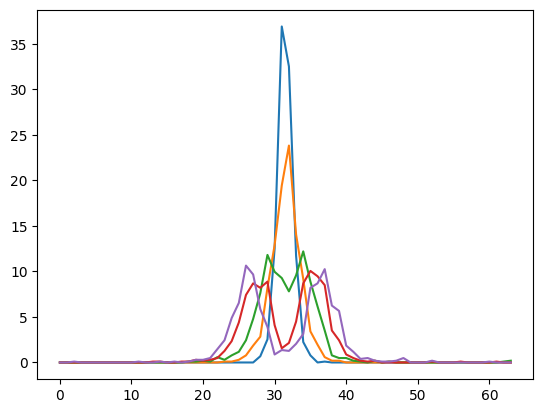

In [8]:
def evolve(iter,wavefunction,n=6,plot=True,hist=True):
    phi = 0.3  # function of time step
    q_reg=QuantumRegister(6)
    aux_reg=QuantumRegister(1)
    clas_reg = ClassicalRegister(6)
    qc=QuantumCircuit(aux_reg,q_reg,clas_reg)
    initialization(qc,wavefunction,q_reg)
    i=0
    snaps=[]
    for i in range(iter):
        apply_QFT(qc,q_reg)
        Time_Evolution(qc,n,q_reg,aux_reg)
        apply_invQFT(qc,q_reg)
        if i%2==0:
            snaps.append(qc.copy())
        i=i+1
    for snap in snaps:
        display_histogram(snap,q_reg,clas_reg,plot=plot,hist=hist)


evolve(iter=10,wavefunction=wavefunction)

e:\miniconda\envs\QGSS\Lib\site-packages\matplotlib\cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
e:\miniconda\envs\QGSS\Lib\site-packages\matplotlib\cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


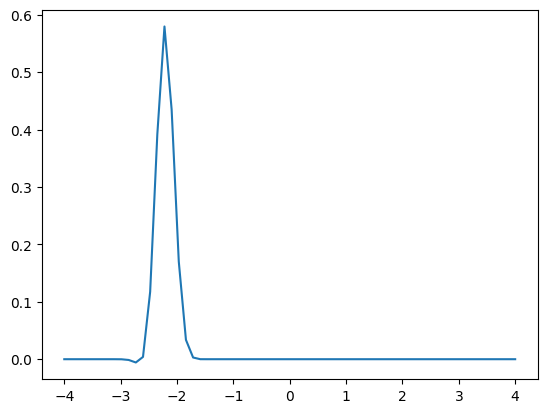

In [17]:
x = np.linspace(-4,4, num=64)



'''wavefunction: guassian wavepacket with moving forward(+ve x axis) in time'''
x0=-2.25
unnormalized_wavefunction= (1/(np.sqrt(2*np.pi)*0.4)*np.exp(-(0.5*(x-x0)**2)/(0.016)))*np.exp(-3j*x)


Normalisation_Constant = np.sqrt(np.sum(np.abs(unnormalized_wavefunction**2)))

forward_wave = (unnormalized_wavefunction)/(Normalisation_Constant)


plt.plot(x,forward_wave)
plt.show()

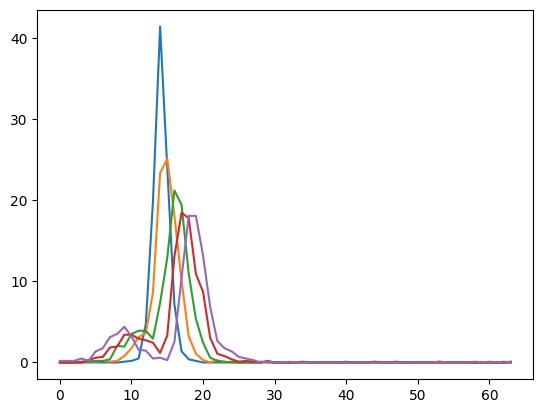

In [18]:
evolve(iter=10,wavefunction=forward_wave,plot=True,hist=False)

In [14]:
import qiskit.version as version
print(version)


<module 'qiskit.version' from 'e:\\miniconda\\envs\\QGSS\\Lib\\site-packages\\qiskit\\version.py'>
